# Linear Regression

We try to find the corelation between two variables.

## Target - Find the correlation between ages and hourly wages.

### Model 1 - Simple Linear Regression

#### Idea

We aim to use simple linear regression to model the relationship between age (`AGE_12`) as the independent variable (feature) and hourly wages (`HRLYEARN`) as the dependent variable (target). The regression model will predict hourly wages based on age. 

The process involves:
1. Splitting the cleaned data into training and testing sets.
2. Training a linear regression model on the training set.
3. Evaluating the model by predicting hourly wages for the test set.
4. Visualizing the results with a scatter plot of actual vs. predicted values.

#### Issues & Troubleshooting

- Issue: "ValueError: Input y contains NaN"
    - Reason: There is "NaN" in the data.
    - Solution: Use `dropna()` to remove the rows with NaN values.
- Issue: "TypeError: can only concatenate str (not "int") to str"
    - Reason: The column index is a string, and we are trying to use it as an integer.
    - Solution: Convert the column index to numeric.
- Issue: The units in the graph are confusing.
    - Reason: Units don't mapped to real-world values.
    - Solution: Read label mapping from another file (REF_TABLE).
- Issue: Logic become complicated after adding mapping.
    - Reason: Data unifying is mixed with data processing.
    - Solution: Separate data unifying and data processing into different functions.

#### Result Evaluation

We use several metrics to evaluate the model's performance:

- MAE (Mean Absolute Error)
    - The average of the absolute differences between predicted and actual values.
    - This metric gives us an idea of how far off our predictions are from the actual values.
    - The value range is from 0 to infinity, lower is better.
- MSE (Mean Squared Error)
    - The average of the squared differences between predicted and actual values.
    - Compared to MAE, MSE gives more weight to larger errors, making it sensitive to outliers.
    - The value range is from 0 to infinity, lower is better.
- Mean Error
    - RMSE (Root Mean Squared Error) with Percentage Error Relative to Mean Prediction.
    - It provides a normalized measure of the error as a percentage of the average predicted value.
    - The value range is from 0% to 100%, lower is better.
- Determination Coefficient (R Square)
    - A statistical measure that represents the proportion of the variance for the dependent variable that's explained by the independent variable(s) in the model.
    - It indicates how well the independent variable(s) explain the variability of the dependent variable.
    - The value range is from 0 to 1, higher is better.

The mean error is 52.3%, which is not accurate enough for a linear regression model. This indicates that the model's predictions are, on average, 52.3% off from the actual hourly wages.

But we can still get some insights from the graph. The wages are increasing with age in a general sense. This may caused by the fact that older people have more experience and are more likely having a higher position in the company.

#### Code & Explanation

Import necessary libraries.

In [83]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model, model_selection
from sklearn.metrics import mean_squared_error

Initialize a DataFrame to store results.

In [84]:
results_df = pd.DataFrame(
    columns=[
        "Record Time",
        "Train Time (s)",
        "Model Name",
        "Feature Columns",
        "Target Column",
        "Mean Error (%)",
        "Model Determination Score (%)",
    ]
)
output_excel_file = "regression_results.xlsx"
output_csv_file = "regression_results.csv"

Load data.

In [85]:
WAGE_0225 = "../data/pub0225.csv"
wage_df = pd.DataFrame(pd.read_csv(WAGE_0225))

Load reference table.

In [86]:
REF_TABLE = "../data/LFS_PUMF_EPA_FGMD_codebook_formatted.xlsx"
ref_df = pd.DataFrame(pd.read_excel(REF_TABLE))
ref_df_lower = ref_df.map(lambda x: x.lower() if isinstance(x, str) else x)

Get mapping between "column name" and "human readable name".

In [87]:
def get_human_name(col: str) -> str:
    """
    Get the human-readable name for a given column.
    """
    col_lower = col.lower()

    locations = ref_df_lower[ref_df_lower.isin([col_lower])].stack().index
    if len(locations) != 1:
        raise ValueError(f"expected 1 location for {col_lower}, found {len(locations)}")

    location = locations[0]
    row_index, col_index = location

    # Convert column index to integer if it's a string.
    if isinstance(col_index, str):
        col_index = ref_df_lower.columns.get_loc(col_index)

    mapped_label = ref_df_lower.loc[row_index, ref_df_lower.columns[col_index + 1]]
    return mapped_label


column_names = wage_df.columns.tolist()
column_name_map = dict()
for col in column_names:
    try:
        human_name = get_human_name(col)
        column_name_map[col] = human_name
    except ValueError:
        print(f"Warning: {col} not found in reference table.")
        pass
print(column_names)
print(column_name_map)

# set some columns manually
column_name_map.clear()
column_name_map["AGE_12"] = "Age"
column_name_map["HRLYEARN"] = "Wage (CAD/hour)"
column_name_map["LFSSTAT"] = "Employment Status"
column_name_map["FTPTMAIN"] = "Full/Part Time"

['REC_NUM', 'SURVYEAR', 'SURVMNTH', 'LFSSTAT', 'PROV', 'CMA', 'AGE_12', 'AGE_6', 'GENDER', 'MARSTAT', 'EDUC', 'MJH', 'EVERWORK', 'FTPTLAST', 'COWMAIN', 'IMMIG', 'NAICS_21', 'NOC_10', 'NOC_43', 'YABSENT', 'WKSAWAY', 'PAYAWAY', 'UHRSMAIN', 'AHRSMAIN', 'FTPTMAIN', 'UTOTHRS', 'ATOTHRS', 'HRSAWAY', 'YAWAY', 'PAIDOT', 'UNPAIDOT', 'XTRAHRS', 'WHYPT', 'TENURE', 'PREVTEN', 'HRLYEARN', 'UNION', 'PERMTEMP', 'ESTSIZE', 'FIRMSIZE', 'DURUNEMP', 'FLOWUNEM', 'UNEMFTPT', 'WHYLEFTO', 'WHYLEFTN', 'DURJLESS', 'AVAILABL', 'LKPUBAG', 'LKEMPLOY', 'LKRELS', 'LKATADS', 'LKANSADS', 'LKOTHERN', 'PRIORACT', 'YNOLOOK', 'TLOLOOK', 'SCHOOLN', 'EFAMTYPE', 'AGYOWNK', 'FINALWT']
{'REC_NUM': 'order of record in file', 'SURVYEAR': 'survey year', 'SURVMNTH': 'survey month', 'PROV': 'province', 'CMA': 'nine largest cmas', 'AGE_12': 'five-year age group of respondent', 'GENDER': 'gender of respondent', 'MARSTAT': 'marital status of respondent', 'EDUC': 'highest educational attainment', 'MJH': 'single or multiple jobholder',

Unify data.

In [88]:
def unify(df: pd.DataFrame) -> pd.DataFrame:
    """
    Unify the DataFrame by applying suitable transformations to each column.

    Args:
        df (pd.DataFrame): The DataFrame to unify.

    Returns:
        pd.DataFrame: The unified DataFrame.
    """
    df["HRLYEARN"] = df["HRLYEARN"] / 100
    return df


wage_df = unify(wage_df)
print(wage_df["HRLYEARN"].head())

0      NaN
1    43.71
2    60.10
3      NaN
4    90.30
Name: HRLYEARN, dtype: float64


#### Core Code

Regression model.

got a DataFrame with 113780 rows and 60 columns
run linear regression, feature: AGE_12, target: HRLYEARN
dropped missing values, now working with 57015 rows
feature shape: (57015, 1), target shape: (57015,)
training feature shape: (38200, 1), training target shape: (38200,)


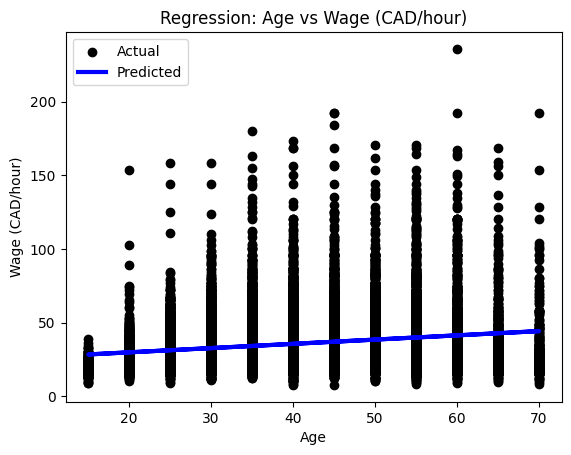

mean error: 18.6 (52.3%)
model determination score: 0.0462


,Coefficient,Intercept
0,0.288442,24.018332


In [89]:
def regression_linear(df: pd.DataFrame, feature_column: str, target_column: str):
    """
    Perform regression analysis on the given DataFrame.

    Args:
        df (pd.DataFrame): The DataFrame containing the data.
        feature_column (str): The name of the feature column.
        target_column (str): The name of the target column.

    Returns:
        pd.DataFrame: The modified DataFrame with regression results.
    """
    print(f"got a DataFrame with {df.shape[0]} rows and {df.shape[1]} columns")
    print(f"run linear regression, feature: {feature_column}, target: {target_column}")

    df_cleaned = df.dropna(subset=[feature_column, target_column])
    print(f"dropped missing values, now working with {df_cleaned.shape[0]} rows")

    feature = df_cleaned[[feature_column]].values.reshape(-1, 1)
    feature = 10 + feature * 5
    target = df_cleaned[target_column].values

    print(f"feature shape: {feature.shape}, target shape: {target.shape}")

    # 1. Splitting the cleaned data into training and testing sets.
    feature_train, feature_test, target_train, target_test = (
        model_selection.train_test_split(
            feature, target, test_size=0.33, random_state=42
        )
    )

    print(
        f"training feature shape: {feature_train.shape}, training target shape: {target_train.shape}"
    )

    # 2. Training a linear regression model on the training set.
    model = linear_model.LinearRegression()
    model.fit(feature_train, target_train)

    # 3. Evaluating the model by predicting hourly wages for the test set.
    target_pred = model.predict(feature_test)

    # 4. Visualizing the results with a scatter plot of actual vs. predicted values.
    feature_column = column_name_map[feature_column]
    target_column = column_name_map[target_column]

    plt.scatter(feature_test, target_test, color="black", label="Actual")
    plt.plot(feature_test, target_pred, color="blue", linewidth=3, label="Predicted")
    plt.xlabel(feature_column)
    plt.ylabel(target_column)
    plt.title(f"Regression: {feature_column} vs {target_column}")
    plt.legend()
    plt.show()

    rmse = np.sqrt(mean_squared_error(target_test, target_pred))
    print(f"mean error: {rmse:3.3} ({rmse/np.mean(target_pred)*100:3.3}%)")

    score = model.score(feature_test, target_test)
    print(f"model determination score: {score:3.3}")

    results = pd.DataFrame(
        {"Coefficient": model.coef_, "Intercept": [model.intercept_]}
    )
    return results


regression_linear(wage_df, "AGE_12", "HRLYEARN")

### Model 2 - Polynomial Regression

#### Idea

Polynomial regression is an extension of simple linear regression that allows us to model non-linear relationships between the independent variable (`AGE_12`) and the dependent variable (`HRLYEARN`). While simple linear regression assumes a straight-line relationship, polynomial regression can capture more complex patterns by introducing polynomial terms (e.g., squared or cubic terms) of the independent variable.

#### Why Try Polynomial Regression?

After using simple linear regression, we may observe that the relationship between `AGE_12` and `HRLYEARN` is not perfectly linear. For example:
- The residuals (errors) from the linear regression model may show a pattern, indicating that a straight line is not the best fit.
- The data may exhibit curvature or other non-linear trends that a linear model cannot capture.

Polynomial regression allows us to address these issues by fitting a curve to the data, which can better capture the underlying relationship.

#### Difference Between Simple Linear Regression and Polynomial Regression

1. **Model Assumption**:
   - Simple linear regression assumes a linear relationship between the independent and dependent variables.
   - Polynomial regression assumes a non-linear relationship by introducing polynomial terms.

2. **Features**:
   - Simple linear regression uses the original feature (`AGE_12`) as is.
   - Polynomial regression transforms the feature into polynomial terms (e.g., `AGE_12`, `AGE_12^2`, `AGE_12^3`, etc.).

3. **Flexibility**:
   - Simple linear regression is limited to straight-line fits.
   - Polynomial regression can fit curves, making it more flexible for capturing non-linear patterns.

4. **Overfitting Risk**:
   - Simple linear regression has a lower risk of overfitting due to its simplicity.
   - Polynomial regression, especially with higher degrees, can overfit the data if not used carefully.

By trying polynomial regression, we aim to improve the model's ability to capture the relationship between `AGE_12` and `HRLYEARN`, especially if the data shows non-linear trends.

Add a data export API.

In [90]:
def export(result: pd.DataFrame):
    """
    Export the results DataFrame to an Excel file and a CSV file.

    Args:
        result (pd.DataFrame): The DataFrame to export.
    """
    global results_df
    results_df = pd.concat([results_df, result], ignore_index=True)

    results_df.to_excel(output_excel_file, index=False)
    print(f"results written to {output_excel_file}")
    results_df.to_csv(output_csv_file, index=False)
    print(f"results written to {output_csv_file}")

#### Core Code

Abastract the regression process into a function.

In [91]:
import time
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression


def regression_single_feature(
    model,
    df: pd.DataFrame,
    feature_column: str,
    target_column: str,
    model_name: str = "PolynomialRegression",
):
    """
    Perform regression analysis on the given DataFrame.

    Args:
        df (pd.DataFrame): The DataFrame containing the data.
        feature_column (str): The name of the feature column.
        target_column (str): The name of the target column.

    Returns:
        pd.DataFrame: The modified DataFrame with regression results.
    """
    start_time = time.time()

    print("=" * 60)
    print(f"model: {model_name}")
    print("=" * 60)

    print(f"got a DataFrame with {df.shape[0]} rows and {df.shape[1]} columns")
    print(f"run linear regression, feature: {feature_column}, target: {target_column}")

    # df_cleaned = df.dropna(subset=[feature_column, target_column])
    df_cleaned = df.dropna(subset=["LFSSTAT", target_column])
    print(f"dropped missing values, now working with {df_cleaned.shape[0]} rows")

    feature = df_cleaned[[feature_column]].values.reshape(-1, 1)
    # map "AGE_12" to real age [15 - 70]
    feature = 10 + feature * 5

    target = df_cleaned[target_column].values

    print(f"feature shape: {feature.shape}, target shape: {target.shape}")

    # 1. Splitting the cleaned data into training and testing sets.
    feature_train, feature_test, target_train, target_test = (
        model_selection.train_test_split(
            feature, target, test_size=0.33, random_state=42
        )
    )

    print(
        f"training feature shape: {feature_train.shape}, training target shape: {target_train.shape}"
    )

    # 2. Training a linear regression model on the training set.
    model.fit(feature_train, target_train)

    # 3. Evaluating the model by predicting hourly wages for the test set.
    target_pred = model.predict(feature_test)

    # 4. Visualizing the results with a scatter plot of actual vs. predicted values.
    feature_column = column_name_map[feature_column]
    target_column = column_name_map[target_column]

    plt.scatter(feature_test, target_test, color="black", label="Actual")
    plt.plot(feature_test, target_pred, color="blue", linewidth=3, label="Predicted")
    plt.xlabel(feature_column)
    plt.ylabel(target_column)
    plt.title(f"Regression: {feature_column} vs {target_column}")
    plt.legend()
    plt.show()

    rmse = np.sqrt(mean_squared_error(target_test, target_pred))
    print(f"mean error: {rmse:3.3} ({rmse/np.mean(target_pred)*100:3.3}%)")

    score = model.score(feature_test, target_test)
    print(f"model determination score: {score:3.3}")

    train_seconds = time.time() - start_time

    result = pd.DataFrame(
        [
            {
                "Record Time": pd.Timestamp.now(),
                "Train Time (s)": train_seconds,
                "Model Name": model_name,
                "Feature Columns": feature_column,
                "Target Column": target_column,
                "Mean Error": rmse,
                "Mean Error (%)": rmse / np.mean(target_pred) * 100,
                "Model Determination Score (%)": score * 100,
            }
        ]
    )

    export(result)
    return result

Call the function with different models.

model: LinearRegression
got a DataFrame with 113780 rows and 60 columns
run linear regression, feature: AGE_12, target: HRLYEARN
dropped missing values, now working with 57015 rows
feature shape: (57015, 1), target shape: (57015,)
training feature shape: (38200, 1), training target shape: (38200,)


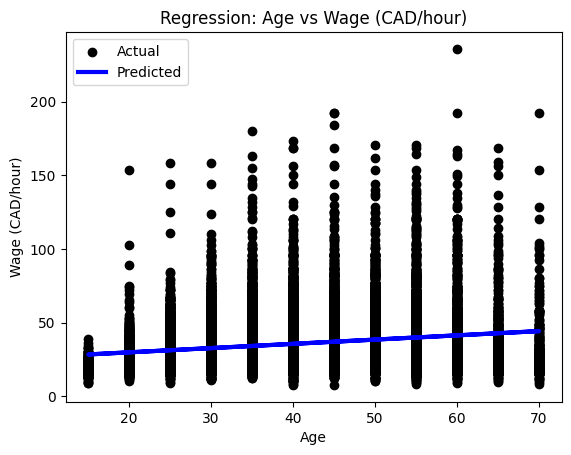

mean error: 18.6 (52.3%)
model determination score: 0.0462
results written to regression_results.xlsx
results written to regression_results.csv
model: PolynomialRegression
got a DataFrame with 113780 rows and 60 columns
run linear regression, feature: AGE_12, target: HRLYEARN
dropped missing values, now working with 57015 rows
feature shape: (57015, 1), target shape: (57015,)
training feature shape: (38200, 1), training target shape: (38200,)


/tmp/ipykernel_3641217/2349803621.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, result], ignore_index=True)


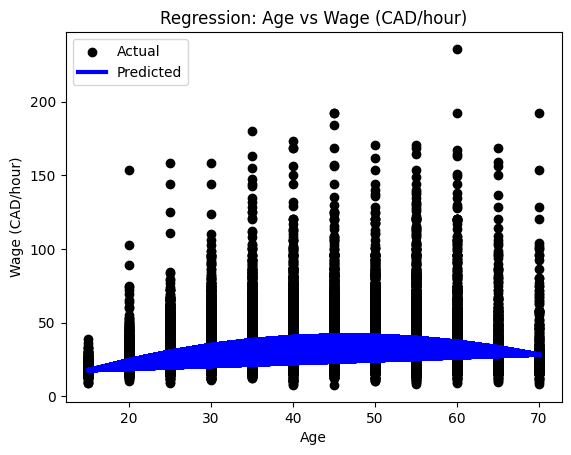

mean error: 17.9 (50.5%)
model determination score: 0.109
results written to regression_results.xlsx
results written to regression_results.csv
model: PolynomialRegression(3)
got a DataFrame with 113780 rows and 60 columns
run linear regression, feature: AGE_12, target: HRLYEARN
dropped missing values, now working with 57015 rows
feature shape: (57015, 1), target shape: (57015,)
training feature shape: (38200, 1), training target shape: (38200,)


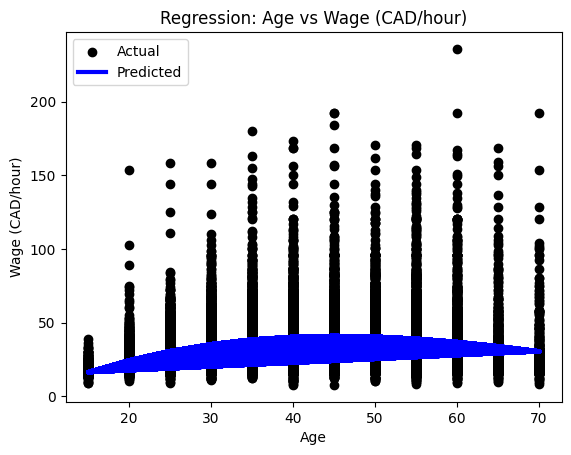

mean error: 17.9 (50.5%)
model determination score: 0.11
results written to regression_results.xlsx
results written to regression_results.csv


,Record Time,Train Time (s),Model Name,Feature Columns,Target Column,Mean Error,Mean Error (%),Model Determination Score (%)
0,2025-04-01 16:56:09.498508,0.329673,PolynomialRegression(3),Age,Wage (CAD/hour),17.9295,50.502116,10.982335


In [92]:
model = LinearRegression()
regression_single_feature(
    model, wage_df, "AGE_12", "HRLYEARN", model_name="LinearRegression"
)

model = make_pipeline(PolynomialFeatures(2), LinearRegression())
regression_single_feature(
    model,
    wage_df,
    "AGE_12",
    "HRLYEARN",
    model_name="PolynomialRegression",
)

model = make_pipeline(PolynomialFeatures(3), LinearRegression())
regression_single_feature(
    model,
    wage_df,
    "AGE_12",
    "HRLYEARN",
    model_name="PolynomialRegression(3)",
)

Q: Why PolynomialFeatures Alone Doesn't Work?

A: PolynomialFeatures generates new features by raising the input features to powers up to the specified degree and creating interaction terms.
However, it does not include a mechanism to fit a model or make predictions. It only transforms the input data.

### Model 3 - Polynomial Regression with Categorical Features

#### Idea

This model extends polynomial regression by incorporating categorical features, such as `LFSSTAT` and `EDUC`, to better capture the relationship between `AGE_12` and `HRLYEARN`. Categorical features are transformed into numerical representations using one-hot encoding, allowing the model to account for group-specific effects. Incorporating categorical features helps improve the model's accuracy by considering additional factors that influence hourly earnings, such as employment status and education level. Polynomial regression is then applied to capture non-linear relationships between the features and the target variable. By combining polynomial regression with categorical features, we aim to create a more comprehensive model that better reflects the complexity of real-world data.

#### Issues & Troubleshooting

- Issue: "ValueError: columns overlap but no suffix specified: Index([1, 2], dtype='int64')"
  - Reason: `pd.get_dummies()` function creates dummy variables (one-hot encoding) for categorical columns. When we join multiple DataFrames, some of the resulting columns have the same names (e.g., 1, 2, etc.). Pandas does not allow overlapping column names unless we differentiate them.
  - Solution: Add prefixes to the columns of the DataFrames before joining them. This ensures that the column names are unique and avoids the overlap issue.
- Issue: "ValueError: With n_samples=0, test_size=0.33 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.
  - Reason: The DataFrame is empty after filtering or processing.
  - Solution: Reduce the feature columns to only the necessary ones. Ensure that the DataFrame is not empty before splitting it into training and testing sets.
- Issue: "ValueError: If using all scalar values, you must pass an index"
  - Reason: Creating a pandas DataFrame from a dictionary of scalar values without wrapping the dictionary in a list or providing an index.
  - Solution: Wrap the dictionary in a list.
- Issue: "MemoryError: Unable to allocate 8.51 TiB for an array with shape (38200, 30627051) and data type float64"
  - Reason: The DataFrame is too large to fit into memory.
  - Solution: Reduce the number of features or use a more efficient data structure (e.g., sparse matrix).


#### Core Code

In [93]:
from typing import List
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression


def regression_categorical(
    model,
    df: pd.DataFrame,
    feature_columns: List[str],
    target_column: str,
    model_name: str = "PolynomialRegression + Categorical Features",
):
    """
    Perform regression analysis on the given DataFrame.

    Args:
        df (pd.DataFrame): The DataFrame containing the data.
        feature_columns (List[str]): The list of feature columns.
        target_column (str): The name of the target column.

    Returns:
        pd.DataFrame: The modified DataFrame with regression results.
    """
    start_time = time.time()

    print("=" * 60)
    print(f"model: {model_name}")
    print("=" * 60)

    print(f"got a DataFrame with {df.shape[0]} rows and {df.shape[1]} columns")
    print(
        f"run linear regression, features: {feature_columns}, target: {target_column}"
    )

    df_cleaned = df.dropna(subset=[target_column] + feature_columns)
    print(f"dropped missing values, now working with {df_cleaned.shape[0]} rows")

    feature_dummies = [
        pd.get_dummies(df_cleaned[col], prefix=col) for col in feature_columns
    ]
    feature = pd.concat(feature_dummies, axis=1)
    print(f"feature columns after one-hot encoding:\n{feature.head()}")

    target = df_cleaned[target_column]

    print(f"feature shape: {feature.shape}, target shape: {target.shape}")

    # 1. Splitting the cleaned data into training and testing sets.
    feature_train, feature_test, target_train, target_test = (
        model_selection.train_test_split(
            feature, target, test_size=0.33, random_state=42
        )
    )

    print(
        f"training feature shape: {feature_train.shape}, training target shape: {target_train.shape}"
    )

    # 2. Training a linear regression model on the training set.
    model.fit(feature_train, target_train)

    # 3. Evaluating the model by predicting hourly wages for the test set.
    target_pred = model.predict(feature_test)

    rmse = np.sqrt(mean_squared_error(target_test, target_pred))
    print(f"mean error: {rmse:3.3} ({rmse/np.mean(target_pred)*100:3.3}%)")

    score = model.score(feature_test, target_test)
    print(f"model determination score: {score:3.3}")

    train_seconds = time.time() - start_time

    # before exporting, use human-readable name for columns
    feature_columns = [column_name_map.get(col, col) for col in feature_columns]
    target_column = column_name_map[target_column]

    result = pd.DataFrame(
        [
            {
                "Record Time": pd.Timestamp.now(),
                "Train Time (s)": train_seconds,
                "Model Name": model_name,
                "Feature Columns": feature_columns,
                "Target Column": target_column,
                "Mean Error": rmse,
                "Mean Error (%)": rmse / np.mean(target_pred) * 100,
                "Model Determination Score (%)": score * 100,
            }
        ]
    )

    export(result)
    return result


model = make_pipeline(PolynomialFeatures(2), LinearRegression())
features = ["LFSSTAT"]
regression_categorical(model, wage_df, features, "HRLYEARN")

model = make_pipeline(PolynomialFeatures(2), LinearRegression())
features = ["LFSSTAT", "EDUC"]
regression_categorical(model, wage_df, features, "HRLYEARN")

# issue: takes too much time
model = make_pipeline(PolynomialFeatures(2), LinearRegression())
features = ["LFSSTAT", "EDUC", "NOC_10", "NOC_43", "AGE_12"]
regression_categorical(model, wage_df, features, "HRLYEARN")

model = make_pipeline(PolynomialFeatures(2), LinearRegression())
features = [
    "EDUC",
    "AGE_12",
    "FTPTMAIN",
    "GENDER",
    "IMMIG",
]
regression_categorical(model, wage_df, features, "HRLYEARN")

model: PolynomialRegression + Categorical Features
got a DataFrame with 113780 rows and 60 columns
run linear regression, features: ['LFSSTAT'], target: HRLYEARN
dropped missing values, now working with 57015 rows
feature columns after one-hot encoding:
   LFSSTAT_1  LFSSTAT_2
1       True      False
2       True      False
4       True      False
6       True      False
7       True      False
feature shape: (57015, 2), target shape: (57015,)
training feature shape: (38200, 2), training target shape: (38200,)
mean error: 19.0 (53.7%)
model determination score: -0.00033
results written to regression_results.xlsx
results written to regression_results.csv
model: PolynomialRegression + Categorical Features
got a DataFrame with 113780 rows and 60 columns
run linear regression, features: ['LFSSTAT', 'EDUC'], target: HRLYEARN
dropped missing values, now working with 57015 rows
feature columns after one-hot encoding:
   LFSSTAT_1  LFSSTAT_2  EDUC_0  EDUC_1  EDUC_2  EDUC_3  EDUC_4  EDUC_5  \
1

,Record Time,Train Time (s),Model Name,Feature Columns,Target Column,Mean Error,Mean Error (%),Model Determination Score (%)
0,2025-04-01 16:57:41.547996,4.709975,PolynomialRegression + Categorical Features,"[EDUC, Age, Full/Part Time, GENDER, IMMIG]",Wage (CAD/hour),16.348435,46.04288,25.989692


### Model 4 - Polynomial Regression with Categorical Features (Sparse Matrix)

Identify dense and sparse features.

In [94]:
def calculate_non_null_percentage(df: pd.DataFrame, target_column: str):
    """
    Calculate the non-null percentage for every column in the DataFrame globally
    and when the target column is not null.

    Args:
        df (pd.DataFrame): The DataFrame to analyze.
        target_column (str): The column to filter for non-null values.

    Returns:
        pd.DataFrame: A DataFrame showing non-null percentages globally and when the target column is not null.
    """
    # Calculate global non-null percentage
    global_non_null = df.notnull().mean() * 100

    # Filter rows where the target column is not null
    df_target_not_null = df[df[target_column].notnull()]

    # Calculate non-null percentage when the target column is not null
    target_non_null = df_target_not_null.notnull().mean() * 100

    # Combine results into a DataFrame
    result = pd.DataFrame(
        {
            "Global Non-Null %": global_non_null,
            f"Relative Non-Null to {target_column} %": target_non_null,
        }
    )

    return result


non_null_percentages = calculate_non_null_percentage(wage_df, "HRLYEARN")

dense_columns = non_null_percentages[
    non_null_percentages["Relative Non-Null to HRLYEARN %"] > 70
]
# print(f"Dense columns (more than 70% non-null):\n{dense_columns}")
dense_column_names = dense_columns.index.tolist()
print(f"Dense columns (more than 70% non-null):")
for col in dense_column_names:
    human_name = column_name_map.get(col, "Unknown")
    print(f"  {col} ({human_name})")

Dense columns (more than 70% non-null):
  REC_NUM (Unknown)
  SURVYEAR (Unknown)
  SURVMNTH (Unknown)
  LFSSTAT (Employment Status)
  PROV (Unknown)
  CMA (Unknown)
  AGE_12 (Age)
  GENDER (Unknown)
  MARSTAT (Unknown)
  EDUC (Unknown)
  MJH (Unknown)
  COWMAIN (Unknown)
  IMMIG (Unknown)
  NAICS_21 (Unknown)
  NOC_10 (Unknown)
  NOC_43 (Unknown)
  UHRSMAIN (Unknown)
  AHRSMAIN (Unknown)
  FTPTMAIN (Full/Part Time)
  UTOTHRS (Unknown)
  ATOTHRS (Unknown)
  HRSAWAY (Unknown)
  PAIDOT (Unknown)
  UNPAIDOT (Unknown)
  XTRAHRS (Unknown)
  TENURE (Unknown)
  HRLYEARN (Wage (CAD/hour))
  UNION (Unknown)
  PERMTEMP (Unknown)
  ESTSIZE (Unknown)
  FIRMSIZE (Unknown)
  SCHOOLN (Unknown)
  EFAMTYPE (Unknown)
  FINALWT (Unknown)


#### Core Code

Use sparse matrix for training.

In [95]:
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import hstack


def regression_categorical_sparse(
    model,
    df: pd.DataFrame,
    feature_columns: List[str],
    target_column: str,
    model_name: str = "PolynomialRegression + Sparse Categorical Features",
):
    """
    Perform regression analysis on the given DataFrame.

    Args:
        df (pd.DataFrame): The DataFrame containing the data.
        feature_columns (List[str]): The list of feature columns.
        target_column (str): The name of the target column.

    Returns:
        pd.DataFrame: The modified DataFrame with regression results.
    """
    start_time = time.time()

    print("=" * 60)
    print(f"model: {model_name}")
    print("=" * 60)

    print(f"original DataFrame: {df.shape[0]} rows and {df.shape[1]} columns")

    df_cleaned = df.dropna(subset=[target_column])

    for col in feature_columns:
        # remove sparse columns
        if col not in dense_column_names:
            feature_columns.remove(col)
            print(f"removed sparse column: {col}")
            continue

        # remove columns with more than 10 unique values
        if len(wage_df[col].unique()) > 10:
            feature_columns.remove(col)
            print(f"removed column with more than 10 unique values: {col}")
            continue

        # remove target column
        if col == target_column:
            feature_columns.remove(col)
            print(f"removed target column: {col}")
            continue

        # remove features that will make the DataFrame size below 70% of the original size.
        df_cleaned_new = df_cleaned.dropna(subset=[col])
        if df_cleaned_new.shape[0] < df.shape[0] * 0.7:
            print(f"{col} dropped too many rows, not using it")
            feature_columns.remove(col)
            continue
        else:
            df_cleaned = df_cleaned_new

    print(f"run {model_name}, features: {feature_columns}, target: {target_column}")

    # Use OneHotEncoder with sparse output
    encoder = OneHotEncoder(sparse_output=True)
    sparse_features = encoder.fit_transform(df_cleaned[feature_columns])

    # Combine sparse features with other features if needed
    # Example: Combine with a dense target column
    sparse_data = hstack(
        [sparse_features, df_cleaned[target_column].values.reshape(-1, 1)]
    )

    target = df_cleaned[target_column]

    print(f"sparse_data shape: {sparse_data.shape}, target shape: {target.shape}")

    # Splitting the processed data into training and testing sets.
    feature_train, feature_test, target_train, target_test = (
        model_selection.train_test_split(
            sparse_data, target, test_size=0.33, random_state=42
        )
    )

    print(
        f"training feature shape: {feature_train.shape}, training target shape: {target_train.shape}"
    )

    # Training a regression model on the training set.
    model.fit(feature_train, target_train)

    # Evaluating the model by predicting hourly wages for the test set.
    target_pred = model.predict(feature_test)

    rmse = np.sqrt(mean_squared_error(target_test, target_pred))
    print(f"mean error: {rmse:3.3} ({rmse/np.mean(target_pred)*100:3.3}%)")

    score = model.score(feature_test, target_test)
    print(f"model determination score: {score:3.3}")

    train_seconds = time.time() - start_time

    # before exporting, use human-readable name for columns
    feature_columns = [column_name_map.get(col, col) for col in feature_columns]
    if len(feature_columns) > 7:
        feature_columns = (
            feature_columns[:3] + ["..."] + [f"{len(feature_columns)} columns"]
        )
    target_column = column_name_map[target_column]
    result = pd.DataFrame(
        [
            {
                "Record Time": pd.Timestamp.now(),
                "Train Time (s)": train_seconds,
                "Model Name": model_name,
                "Feature Columns": feature_columns,
                "Target Column": target_column,
                "Mean Error": rmse,
                "Mean Error (%)": rmse / np.mean(target_pred) * 100,
                "Model Determination Score (%)": score * 100,
            }
        ]
    )

    export(result)
    return result

In [96]:
model = make_pipeline(PolynomialFeatures(2), LinearRegression())
features = [
    "LFSSTAT",
    "EDUC",
    "NOC_10",
    "AGE_12",
    "YABSENT",
    "FTPTMAIN",
    "EVERWORK",
    "GENDER",
    "CMA",
    "IMMIG",
]
regression_categorical_sparse(
    model,
    wage_df,
    features,
    "HRLYEARN",
)

model: PolynomialRegression + Sparse Categorical Features
original DataFrame: 113780 rows and 60 columns
LFSSTAT dropped too many rows, not using it
removed column with more than 10 unique values: NOC_10
removed sparse column: YABSENT
removed sparse column: EVERWORK
CMA dropped too many rows, not using it
run PolynomialRegression + Sparse Categorical Features, features: ['EDUC', 'AGE_12', 'FTPTMAIN', 'GENDER', 'IMMIG'], target: HRLYEARN
sparse_data shape: (57015, 27), target shape: (57015,)
training feature shape: (38200, 27), training target shape: (38200,)
mean error: 0.00153 (0.0043%)
model determination score: 1.0
results written to regression_results.xlsx
results written to regression_results.csv


,Record Time,Train Time (s),Model Name,Feature Columns,Target Column,Mean Error,Mean Error (%),Model Determination Score (%)
0,2025-04-01 16:57:41.832483,0.196094,PolynomialRegression + Sparse Categorical Feat...,"[EDUC, Age, Full/Part Time, GENDER, IMMIG]",Wage (CAD/hour),0.001533,0.004302,99.999999


In [97]:
# train on all columns
model = make_pipeline(PolynomialFeatures(2), LinearRegression())
features = column_names
regression_categorical_sparse(model, wage_df, features, "HRLYEARN")

model: PolynomialRegression + Sparse Categorical Features
original DataFrame: 113780 rows and 60 columns
removed column with more than 10 unique values: REC_NUM
SURVMNTH dropped too many rows, not using it
PROV dropped too many rows, not using it
removed column with more than 10 unique values: AGE_12
GENDER dropped too many rows, not using it
EDUC dropped too many rows, not using it
removed sparse column: EVERWORK
COWMAIN dropped too many rows, not using it
removed column with more than 10 unique values: NAICS_21
removed column with more than 10 unique values: NOC_43
removed sparse column: WKSAWAY
removed column with more than 10 unique values: UHRSMAIN
FTPTMAIN dropped too many rows, not using it
removed column with more than 10 unique values: ATOTHRS
removed sparse column: YAWAY
removed column with more than 10 unique values: UNPAIDOT
removed sparse column: WHYPT
removed sparse column: PREVTEN
UNION dropped too many rows, not using it
ESTSIZE dropped too many rows, not using it
remov

,Record Time,Train Time (s),Model Name,Feature Columns,Target Column,Mean Error,Mean Error (%),Model Determination Score (%)
0,2025-04-01 16:58:35.936879,54.074232,PolynomialRegression + Sparse Categorical Feat...,"[SURVYEAR, Employment Status, CMA, ..., 30 col...",Wage (CAD/hour),0.005482,0.015384,99.999992
